In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import dependencies and load dataset**

In [2]:
!pip install keras_applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.4 MB/s eta 0:00:00


In [3]:
!pip -q install bert-for-tf2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2
import sys
import time
import pickle
import plotly.express as px
import plotly.graph_objects as graph_objects
from tqdm import tqdm
import re
import tensorflow_hub as hub
import bert
import warnings

from __future__ import division, print_function
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.utils.layer_utils import get_source_inputs
from keras.utils.data_utils import get_file
from keras.utils import layer_utils
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, callbacks, optimizers, utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, MaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D, Normalization, GlobalAvgPool2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TensorBoard, CSVLogger, EarlyStopping
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input, TimeDistributed, Conv1D, BatchNormalization, MaxPool1D, Concatenate, LSTM, GRU, Multiply, Layer, Average, Lambda, Add, Reshape
from keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg19 import VGG19


IMG1=IMG2=224
max_length = 50

In [ ]:
# Some preprocessing steps, including Stopword removal, Emoticon Conversion, Spelling correction, and Translation are implemented in the "Text_preprocessing notebook", and this is the resulted file
# data=pd.read_csv('/content/drive/MyDrive/NEW_EMO_DATASET/EMO-G.csv')

**Data_Division**

In [ ]:
# num_train = int(data.shape[0]*0.8)
# train_df = data.iloc[:num_train, :]
# test = data.iloc[num_train:, :]

In [ ]:
# num_train = int(train_df.shape[0]*0.8)
# train = train_df.iloc[:num_train, :]
# val = train_df.iloc[num_train:, :]

In [ ]:
# train.to_csv('/content/drive/MyDrive/NEW_EMO_DATASET/E_train.csv', index=False)
# val.to_csv('/content/drive/MyDrive/NEW_EMO_DATASET/E_val.csv', index=False)
# test.to_csv('/content/drive/MyDrive/NEW_EMO_DATASET/E_test.csv', index=False)

In [5]:
train=pd.read_csv('/content/drive/MyDrive/NEW_EMO_DATASET/E_train.csv')
val=pd.read_csv('/content/drive/MyDrive/NEW_EMO_DATASET/E_val.csv')
test=pd.read_csv('/content/drive/MyDrive/NEW_EMO_DATASET/E_test.csv')
print(train.shape, val.shape, test.shape)

(12628, 3) (3157, 3) (3947, 3)


In [6]:
train['label'] = train['label'].str.strip()
label_counts = train['label'].value_counts()
print(label_counts)
print(train.info())

Happy      3687
Angry      3301
Sad        3161
Disgust    2479
Name: label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12628 entries, 0 to 12627
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12628 non-null  object
 1   label   12628 non-null  object
 2   image   12628 non-null  object
dtypes: object(3)
memory usage: 296.1+ KB
None


In [7]:
# Check number of classes
nClasses = train.label.nunique()
print(nClasses)

4


**Text_Cleaning**

In [8]:
# cleaning text function

def preprocess_text(sen):
  # removing html tags
  sentence = remove_tags(sen)

  # remove punctuations and numbers
  sentence = re.sub('[^a-zA-Z]', " ", sentence)
  sentence = re.sub(r'[0-9]', " ", sentence)

  # single character reomval
  sentence = re.sub(r"\s+[a-zA-Z]\s+", " ", sentence)

  # remove multiple spaces
  sentence = re.sub(r"\s+", " ", sentence)

  sentence = sentence.lower()

  return sentence

def remove_tags(text):
  return TAG_RE.sub("", text)

TAG_RE = re.compile(r'<[^>]+>')

In [9]:
# Define a vectorized function which takes a nested sequence of objects or
# numpy arrays as inputs and returns a single numpy array or a tuple of numpy arrays.

vec_preprocess_text = np.vectorize(preprocess_text)

In [10]:
# Import the BERT Base model from tensorflow_hub (layer, vocab_file and tokenizer)

BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [11]:
# preprocessing of text according to BERT

def get_masks(text, max_length):
  """Mask for padding"""
  tokens = tokenizer.tokenize(text)
  tokens = ['[CLS'] + tokens + ['[SEP]']
  length = len(tokens)
  if length > max_length:
    tokens = tokens[:max_length]
  return np.asarray([1]*len(tokens) + [0]*(max_length-len(tokens)))

vec_get_masks = np.vectorize(get_masks, signature='(),()->(n)')

In [12]:
def get_segments(text, max_length):
  """Segments: 0 for the first sequence, 1 for the second"""
  tokens = tokenizer.tokenize(text)
  tokens = ['[CLS]'] + tokens + ['[SEP]']
  length = len(tokens)
  if length > max_length:
    tokens = tokens[:max_length]

  segments = []
  current_segment_id = 0
  with_tags = ['[CLS]'] + tokens + ['[SEP]']
  token_ids = tokenizer.convert_tokens_to_ids(tokens)

  for token in tokens:
    segments.append(current_segment_id)
    if token == "[SEP]":
      current_segment_id = 1

  return np.asarray(segments + [0]*(max_length-len(tokens)))

vec_get_segments = np.vectorize(get_segments, signature='(),()->(n)')

In [13]:
def get_ids(text, tokenizer, max_length):
  """Token ids form Tokenizer vocab"""
  tokens = tokenizer.tokenize(text)
  tokens = ['[CLS]'] + tokens + ['[SEP]']
  length = len(tokens)
  if length > max_length:
    tokens = tokens[:max_length]

  token_ids = tokenizer.convert_tokens_to_ids(tokens)
  input_ids = np.asarray(token_ids + [0]*(max_length-length))
  return input_ids

vec_get_ids = np.vectorize(get_ids, signature='(),(),()->(n)')

In [14]:
def prepare(text_array, tokenizer, max_length=50):
  ids = vec_get_ids(text_array, tokenizer, max_length).squeeze()
  masks = vec_get_masks(text_array, max_length).squeeze()
  segments = vec_get_segments(text_array, max_length).squeeze()

  return ids, segments, masks

In [15]:
encoder = LabelEncoder()
processed_train = vec_preprocess_text(train.text.values)
processed_val = vec_preprocess_text(val.text.values)
processed_test = vec_preprocess_text(test.text.values)


encoded_labels_train = encoder.fit_transform(train.label.values)
labels_train = utils.to_categorical(encoded_labels_train, nClasses)

encoded_labels_val = encoder.fit_transform(val.label.values)
labels_val = utils.to_categorical(encoded_labels_val, nClasses)

encoded_labels_test = encoder.fit_transform(test.label.values)
labels_test = utils.to_categorical(encoded_labels_test, nClasses)

print("Processed text sample:", processed_test[0])
print("Shape of test labels:", labels_test.shape)
# ------------------------------------------------------------------------------

ids_train, segments_train, masks_train = prepare(processed_train,
                                                 tokenizer,
                                                 max_length)

ids_val, segments_val, masks_val = prepare(processed_val,
                                                 tokenizer,
                                                 max_length)

ids_test, segments_test, masks_test = prepare(processed_test,
                                               tokenizer,
                                               max_length)

Processed text sample: protestor throws stone rebel terrorist throwing phases armed violence state rebellion riot ideological protest movement guerrilla warfare
Shape of test labels: (3947, 4)


In [16]:
data_dict_train = dict(())
data_dict_train['image'] = train['image']
data_dict_train['ids'] = ids_train
data_dict_train['segments'] = segments_train
data_dict_train['masks'] = masks_train
data_dict_train['labels'] = labels_train


data_dict_val = dict(())
data_dict_val['image'] = val['image']
data_dict_val['ids'] = ids_val
data_dict_val['segments'] = segments_val
data_dict_val['masks'] = masks_val
data_dict_val['labels'] = labels_val


data_dict_test = dict(())
data_dict_test['image'] = test['image']
data_dict_test['ids'] = ids_test
data_dict_test['segments'] = segments_test
data_dict_test['masks'] = masks_test
data_dict_test['labels'] = labels_test


def process_data(data):
  image = data['image']
  label = data['labels']
  ids = data['ids']
  segments = data['segments']
  masks = data['masks']

  img = tf.io.read_file(image)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG1,IMG2])
  img = img/255.0

  return ((ids, masks, segments, img), label)

train_data = tf.data.Dataset.from_tensor_slices(data_dict_train)
train_data = train_data.map(process_data)
train_data = train_data.batch(32)
train_data = train_data.prefetch(tf.data.AUTOTUNE)
train_data = train_data.cache()

for [ids, masks, segments, img], label in train_data.take(1):
  print(ids.shape, masks.shape, segments.shape, img.shape, label.shape)


val_data = tf.data.Dataset.from_tensor_slices(data_dict_val)
val_data = val_data.map(process_data)
val_data = val_data.batch(32)
val_data = val_data.prefetch(tf.data.AUTOTUNE)
val_data = val_data.cache()

for [ids, masks, segments, img], label in val_data.take(1):
  print(ids.shape, masks.shape, segments.shape, img.shape, label.shape)


test_data = tf.data.Dataset.from_tensor_slices(data_dict_test)
test_data = test_data.map(process_data)
test_data = test_data.batch(32)
test_data = test_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.cache()

for [ids, masks, segments, img], label in test_data.take(1):
  print(ids.shape, masks.shape, segments.shape, img.shape, label.shape)

(32, 50) (32, 50) (32, 50) (32, 224, 224, 3) (32, 4)
(32, 50) (32, 50) (32, 50) (32, 224, 224, 3) (32, 4)
(32, 50) (32, 50) (32, 50) (32, 224, 224, 3) (32, 4)


**Text Model**

In [1]:
input_word_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_word_ids')
input_mask = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_mask')
segment_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='segment_ids')

den_out, seq_out = bert_layer([input_word_ids, input_mask, segment_ids])
bert = layers.Dense(256, activation="relu", name="Bert")(seq_out)

filter_sizes = [3,4]
convs = []
for filter_size in filter_sizes:
  conv = Conv1D(filters=256, kernel_size=filter_size, padding='same', activation='relu')(seq_out)
  bch = BatchNormalization()(conv)
  pool = MaxPool1D(filter_size)(bch)
  convs.append(pool)
con = Concatenate(axis=1)(convs)

lstm1 = layers.LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.25, name="lstm1")(seq_out)
lstm2 = layers.LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.25, name="lstm2")(lstm1)

output = Concatenate(axis=1)([con, lstm2, bert])
TXT_model = Model([input_word_ids, input_mask, segment_ids], output)

# Keep model layers trainable
for layer in TXT_model.layers:
  layer.trainable = True

**Convolutional Block Attention Module (CBAM)**

In [18]:
def CBAM_Attention(features, ratio=8):
    ch_features = channel_attention(features, ratio)
    sp_features = spatial_attention(ch_features)
    return sp_features

def channel_attention(features, ratio=8):
  channel = features.shape[-1]
  shared_layer_one = Dense(channel//ratio,activation='relu',kernel_initializer='he_normal',use_bias=True,bias_initializer='zeros')
  shared_layer_two = Dense(channel,kernel_initializer='he_normal',use_bias=True,bias_initializer='zeros')

  avg_pool = GlobalAveragePooling2D()(features)
  avg_pool = Reshape((1,1,channel))(avg_pool)
  assert avg_pool.shape[1:] == (1,1,channel)
  avg_pool = shared_layer_one(avg_pool)
  assert avg_pool.shape[1:] == (1,1,channel//ratio)
  avg_pool = shared_layer_two(avg_pool)
  assert avg_pool.shape[1:] == (1,1,channel)

  max_pool = GlobalMaxPooling2D()(features)
  max_pool = Reshape((1,1,channel))(max_pool)
  assert max_pool.shape[1:] == (1,1,channel)
  max_pool = shared_layer_one(max_pool)
  assert max_pool.shape[1:] == (1,1,channel//ratio)
  max_pool = shared_layer_two(max_pool)
  assert max_pool.shape[1:] == (1,1,channel)

  ch_features = Add()([avg_pool,max_pool])
  ch_features = Activation('sigmoid')(ch_features)
  ch_features = Multiply()([features, ch_features])
  return ch_features

def spatial_attention(features):
    kernel_size = 7
    channel = features.shape[-1]
    sp_features = features
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(sp_features)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(sp_features)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    sp_features = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)
    sp_features = K.squeeze(sp_features, axis=-1)
    return sp_features

**VGG16_Places365 for extracting Scene Features**

In [19]:
# Instantiates the VGG16-places365 architecture.Arguments
# include_top: whether to include the 3 fully-connected layers at the top of the network.
# weights: 'places' (pre-training on Places), or the path to the weights file to be loaded.
# input_tensor: optional Keras tensor to use as image input for the model.
# pooling: Optional pooling mode for feature extraction
# classes: optional number of classes (365 number of scene in places_dataset)
# Return: A Keras model instance.

WEIGHTS_PATH = 'https://github.com/GKalliatakis/Keras-VGG16-places365/releases/download/v1.0/vgg16-places365_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/GKalliatakis/Keras-VGG16-places365/releases/download/v1.0/vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5'


def VGG16_Places365(include_top=True, weights='places', input_tensor=None, pooling=None, classes=365):

    model = tf.keras.models.Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', name='block1_conv1', input_shape=(IMG1, IMG2, 3)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', name='block1_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name="block1_pool"))

    # Block 2
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu', name='block2_conv1'))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu', name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name="block2_pool"))

    # Block 3
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', name='block3_conv1'))
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', name='block3_conv2'))
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', name='block3_conv3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name="block3_pool"))

    # Block 4
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu', name='block4_conv1'))
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu', name='block4_conv2'))
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu', name='block4_conv3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name="block4_pool"))

    # Block 5
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu', name='block5_conv1'))
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu', name='block5_conv2'))
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu', name='block5_conv3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name="block5_pool"))

    if include_top:
        # Classification block
        model.add(layers.Flatten())
        model.add(layers.Dense(4096, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(4096, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(365, activation='softmax'))

    else:
        if pooling == 'avg':
            model.add(GlobalAveragePooling2D())
        elif pooling == 'max':
            model.add(GlobalMaxPooling2D())

    # load weights
    if weights == 'places':
        if include_top:
            weights_path = get_file('vgg16-places365_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')

        model.load_weights(weights_path)

    return model

In [20]:
svgg_base_model = VGG16_Places365(include_top=False, weights='places', input_tensor=Input(shape=(IMG1, IMG2, 3)))

svgg_base_model.trainable = False
s = svgg_base_model.layers[-2].output
simage_model = Model(inputs=svgg_base_model.input, outputs=s)

# Keep model layers trainable
for layer in simage_model.layers:
  layer.trainable = True

58909656/58909656 [==============================] - 0s 0us/step


**VGG19_Imagenet for extracting Region Features**

In [21]:
rvgg_base_model = VGG19(include_top=False, weights='imagenet', input_tensor=Input(shape=(IMG1, IMG2, 3)))
rvgg_base_model.trainable = False
r = rvgg_base_model.layers[-2].output
rimage_model = Model(inputs=rvgg_base_model.input, outputs=r)

# Keep model layers trainable
for layer in rimage_model.layers:
  layer.trainable = True

80134624/80134624 [==============================] - 0s 0us/step


In [22]:
class SelfAttention(Layer):
    def __init__(self,**kwargs):
        super(SelfAttention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), initializer='random_normal')
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), initializer='zeros')
        super(SelfAttention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

**Text_Spatial_Replicate**

In [23]:
def spatial_replicate(x):
  # increase dimenion with reshape to create 3th dimension
  x = Reshape((1, x.shape[-1]))(x)
  # concatinate data with itself to replicate it
  spatial_layer1 = Concatenate(axis = 1)([x, x])
  # Repeat concatination to replicate 12 times
  for i in range(12):
    spatial_layer1 = Concatenate(axis = 1)([spatial_layer1, x])
  # increase dimension with reshape to create 4th dimension
  spatial_layer1 = Reshape((1,spatial_layer1.shape[1], spatial_layer1.shape[-1]))(spatial_layer1)
  # concatinate data with itself to replicate it
  spatial_layer2 = Concatenate(axis = 1)([spatial_layer1, spatial_layer1])
  for i in range(12) :
    spatial_layer2 =  Concatenate(axis = 1)([spatial_layer2, spatial_layer1])
  return spatial_layer2

**Textual-guided Attention Module**

In [24]:
class Attention(Layer):
    def __init__(self,**kwargs):
        super(Attention,self).__init__(**kwargs)

    def build(self,input_shape):
        input_shape=input_shape[0] # create the dimensions required for the weights W and b within the build method.
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self,features):
      # extract the two sets of features from the input.
      img_features = features[0]
      txt_features = features[1]
      # calculates the element-wise multiplication.
      joint_features = Multiply()([img_features,txt_features])
      # computes alignment scores
      score = K.squeeze(K.tanh(K.dot(joint_features,self.W)+self.b),axis=-1)
      # computes the softmax of the alignment scores to obtain attention weights.
      alpha = K.softmax(score)
      # Reshape to tensorFlow format
      alpha = K.expand_dims(alpha, axis=-1)
      # computes the attended image features
      img_features_attended = alpha * img_features
      img_features_sum =  K.sum(img_features_attended, axis=1)
      return img_features_sum

In [25]:
# The MultiHeadAttention class imported from the keras_multi_head 
# https://github.com/CyberZHG/keras-multi-head/blob/7175503ff350ba451e07558634bbd79255560c0c/keras_multi_head/multi_head_attention.py#L4

!pip install keras-multi-head

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras-multi-head: filename=keras_multi_head-0.29.0-py3-none-any.whl size=14977 sha256=e0ec07321c1747041b266733ee870671838344bc8477f3df11decf2d01a04cdf
  Stored in directory: /root/.cache/pip/wheels/cb/23/4b/06d7ae21714f70fcc25b48f972cc8e5e7f4b6b764a038b509d
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=992971c24d63a2811b9f821363ab63ee2786a11f012930f448fb09d4bfbd9f16
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-multi-head keras-self-attention


In [26]:
from keras_multi_head import MultiHeadAttention

input_word_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_word_ids')
input_mask = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_mask')
segment_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='segment_ids')
image_input = layers.Input(shape =(IMG1,IMG2,3), dtype=tf.float32, name='image_input')

# 1) FEATURE LEARNING
Ft = TXT_model([input_word_ids, input_mask, segment_ids])

Vr = rimage_model(image_input)
Fr = Dense(256, activation = 'relu')(Vr)

Vs = simage_model(image_input)
Fs = Dense(256, activation = 'relu')(Vs)
# ------------------------------------------------------------------------------
# Text_spatial_replicate
Ft_dash = GlobalAveragePooling1D()(Ft)
Ft_dash = Dense(256 , activation = 'relu')(Ft_dash)
Ft_dash = spatial_replicate(Ft_dash)
# ------------------------------------------------------------------------------
# 2) ATTENTIVE INTERACTION LEARNING

 # Regional attention network
Fer = Attention()([Fr , Ft_dash])
Fr_dash = Dense(256, activation='relu')(Fer)

Ms = CBAM_Attention(Vr)
Ms_dash = Dense(256, activation='relu')(Ms)
Far = Multiply()([Ms_dash, Fr_dash])

 # Textual attention network
Fat = SelfAttention()(Ft)
Fat = Reshape((1, Fat.shape[-1]))(Fat)

 # Scene attention network
Fes = Attention()([Fs, Ft_dash])
Fs_dash = Dense(256, activation='relu')(Fes)

Zs = CBAM_Attention(Vs)
Zs_dash = Dense(256, activation='relu')(Zs)
Fas = Multiply()([Zs_dash, Fs_dash])
# ------------------------------------------------------------------------------
# 3) CROSS-MODAL FUSION LEARNING

 # Up-sampling
Far_dash = Dense(256, activation = 'relu')(Far)
Fat_dash = Dense(256, activation='relu')(Fat)
Fas_dash = Dense(256, activation = 'relu')(Fas)

 # Cross-modal fusion layer
Frs = Multiply()([Far_dash, Fas_dash])
input_query = Lambda(lambda x: K.l2_normalize(x,axis=-1))(Frs)

Ftr = Multiply()([Fat_dash, Far_dash])
input_key = Lambda(lambda x: K.l2_normalize(x,axis=-1))(Ftr)

Fts = Multiply()([Fat_dash, Fas_dash])
input_value = Lambda(lambda x: K.l2_normalize(x,axis=-1))(Fts)

 # Multi head attention
Att = MultiHeadAttention(head_num=4,name='Multi-Head', )([input_query, input_key, input_value])
Fl = Flatten()(Att)

 # classification layers
Fc = Dense(256, activation='relu', name='Dense1_256')(Fl)
Fc = Dense(256, activation='relu', name='Dense2_256')(Fc)
Fc = Dense(256, activation='relu', name='Dense3_256')(Fc)
Fc = Dense(128, activation='relu', name='Dense4_128')(Fc)
Fse = Dropout(0.5)(Fc)
output = Dense(nClasses, activation='softmax', name='class', kernel_regularizer=l2(0.005), activity_regularizer=l1(0.005))(Fse)
dmvan_model = Model([input_word_ids, input_mask, segment_ids, image_input], output)
dmvan_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 model (Functional)             (None, 128, 256)     112632833   ['input_word_ids[0][0]',         
                                                                  'input_mask[0][0]',       

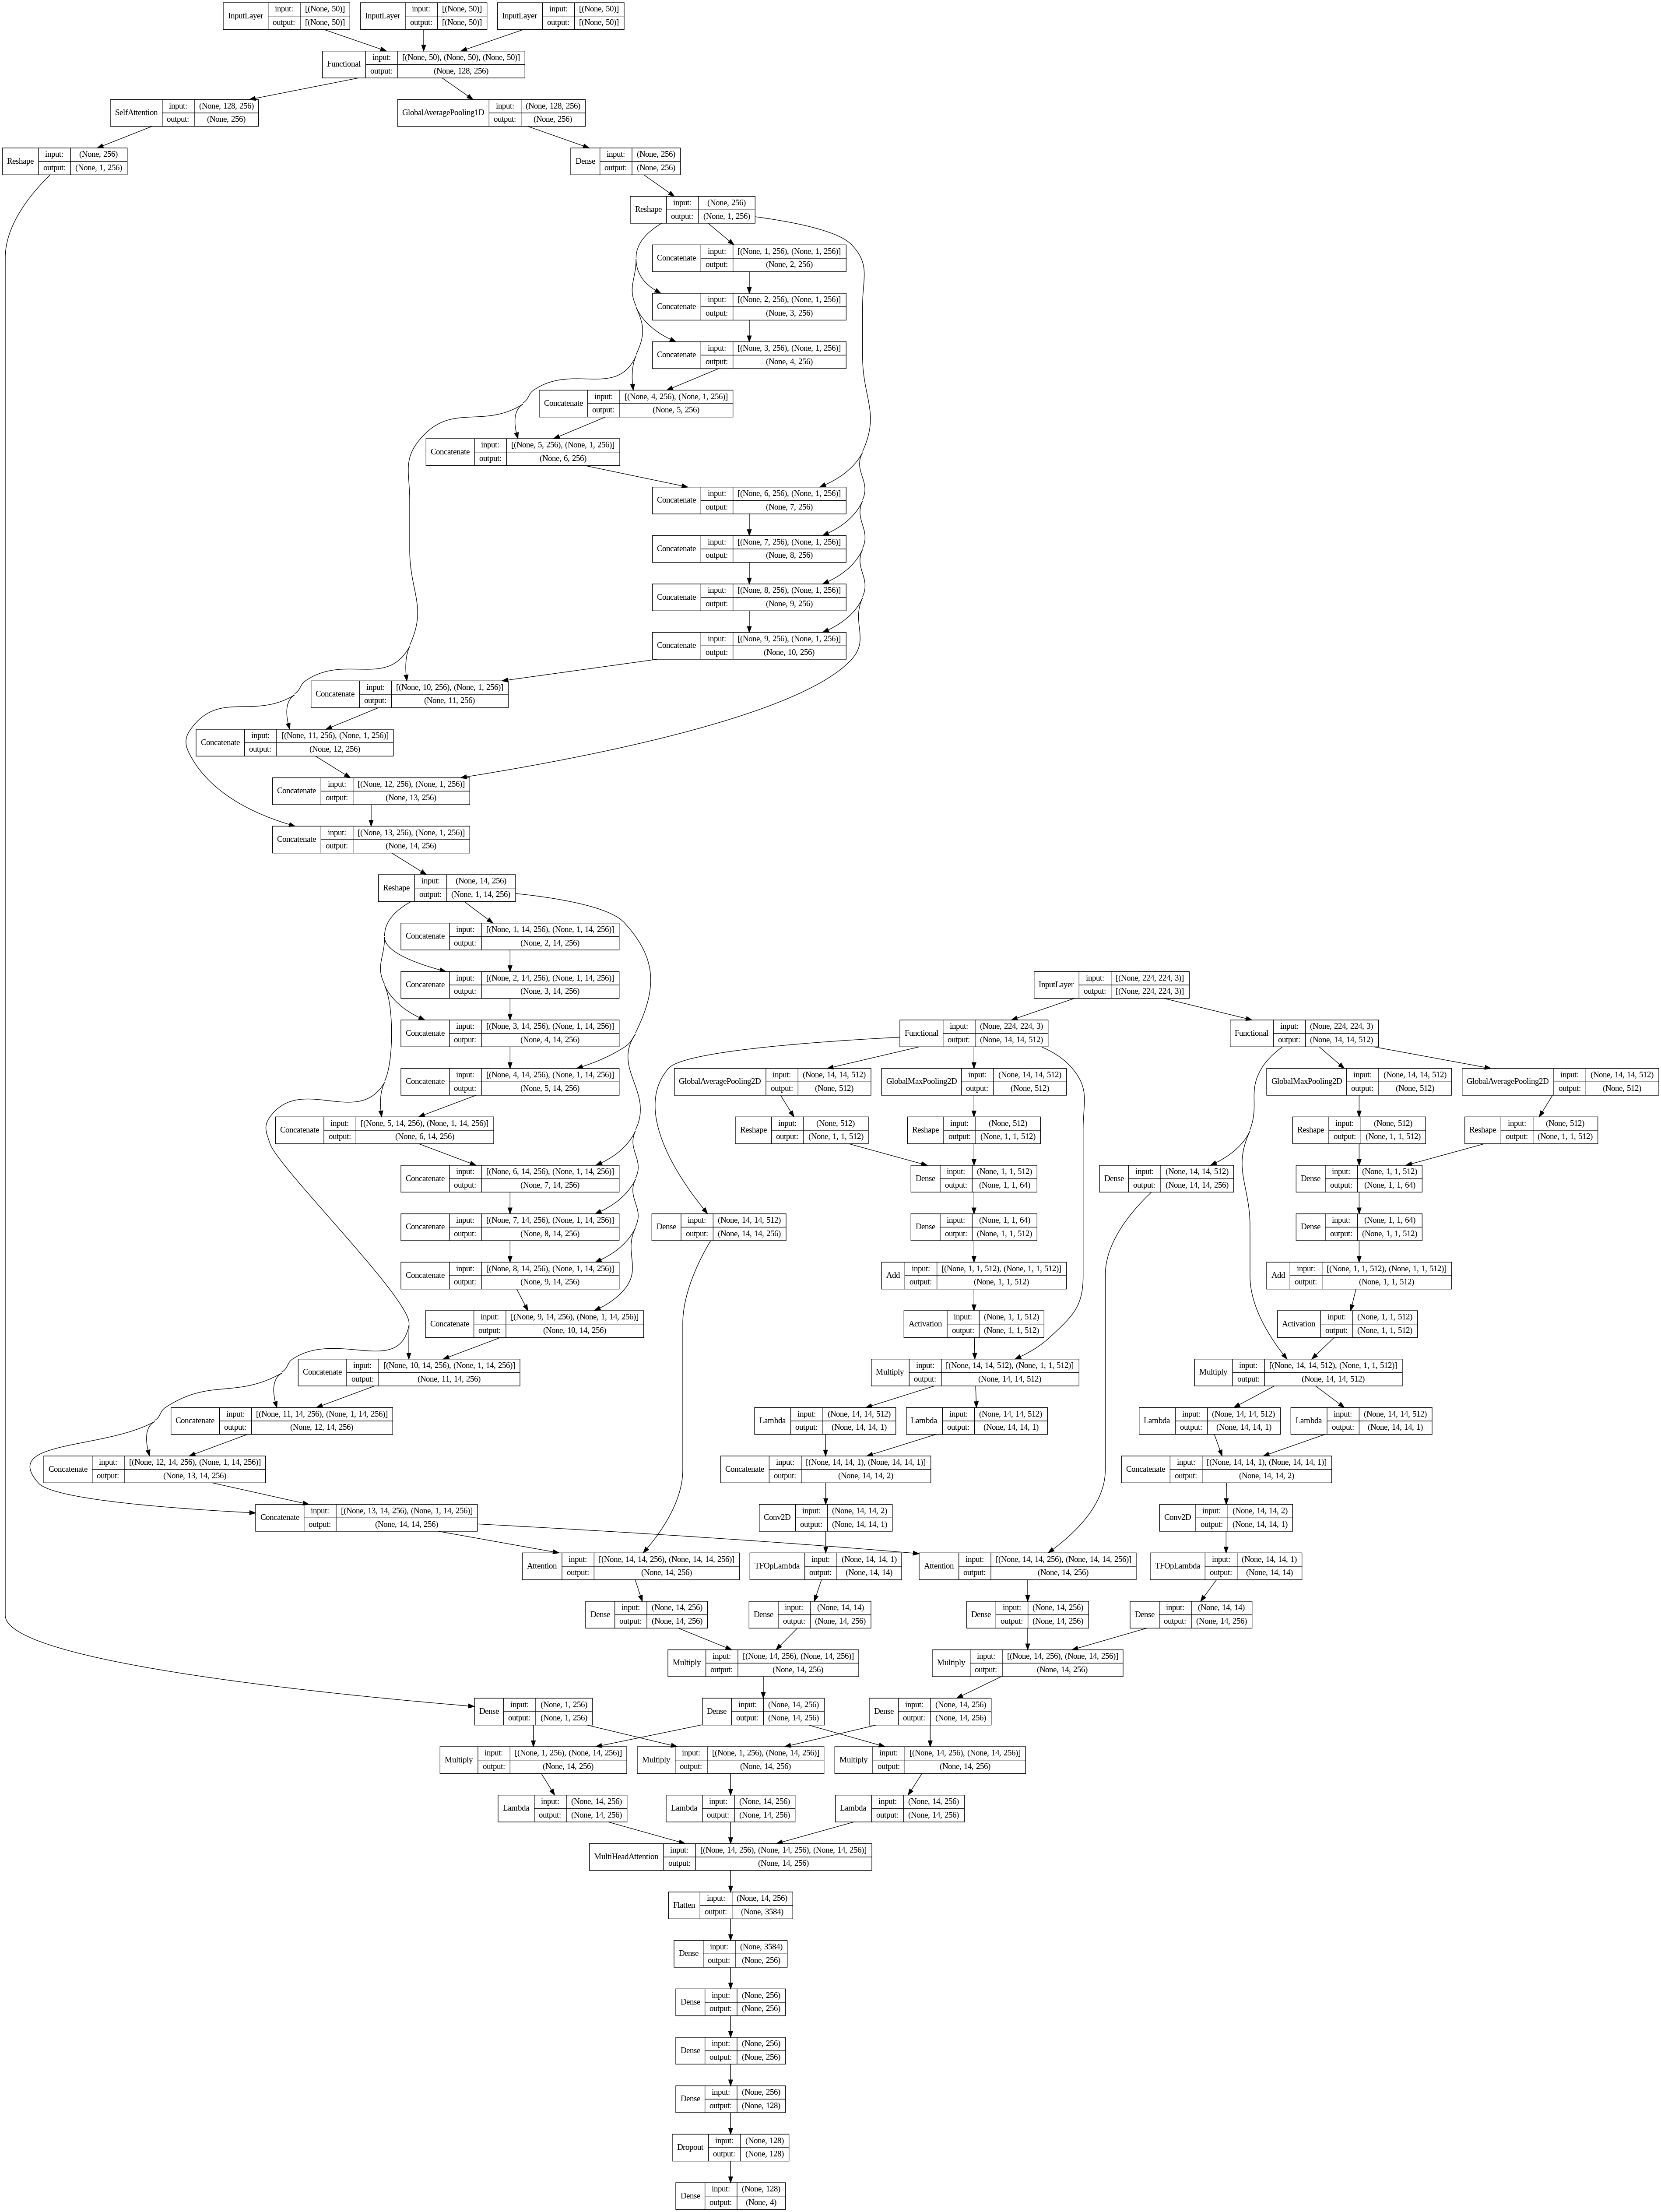

In [27]:
plot_model(dmvan_model, show_shapes=True, show_layer_names=False)

In [28]:
# Stochastic Gradient Descent Optimizer
sgd = SGD(learning_rate=0.0001, momentum=0.9, nesterov=False)
dmvan_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Early stopping
es = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, min_lr=0.00001)

In [ ]:
import keras
import keras.utils
from keras import utils as np_utils

class TRA(keras.callbacks.Callback):
    def __init__(self):
        super(TRA, self).__init__()

    def on_train_begin(self, logs=None):
        self.start_time= time.time()

    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

In [ ]:
history = dmvan_model.fit(train_data, epochs=50, validation_data=val_data, verbose=2, callbacks=[es,reduce_lr,TRA()])

Epoch 1/50
395/395 - 1130s - loss: 1.4240 - accuracy: 0.3466 - val_loss: 1.4191 - val_accuracy: 0.4501 - lr: 1.0000e-04 - 1130s/epoch - 3s/step
Epoch 2/50
395/395 - 182s - loss: 1.4040 - accuracy: 0.4707 - val_loss: 1.3888 - val_accuracy: 0.5131 - lr: 1.0000e-04 - 182s/epoch - 461ms/step
Epoch 3/50
395/395 - 182s - loss: 1.3557 - accuracy: 0.5358 - val_loss: 1.3188 - val_accuracy: 0.5369 - lr: 1.0000e-04 - 182s/epoch - 462ms/step
Epoch 4/50
395/395 - 182s - loss: 1.2569 - accuracy: 0.5562 - val_loss: 1.1841 - val_accuracy: 0.5391 - lr: 1.0000e-04 - 182s/epoch - 460ms/step
Epoch 5/50
395/395 - 182s - loss: 1.0842 - accuracy: 0.5812 - val_loss: 0.9698 - val_accuracy: 0.6183 - lr: 1.0000e-04 - 182s/epoch - 460ms/step
Epoch 6/50
395/395 - 183s - loss: 0.8780 - accuracy: 0.6886 - val_loss: 0.7788 - val_accuracy: 0.7251 - lr: 1.0000e-04 - 183s/epoch - 463ms/step
Epoch 7/50
395/395 - 182s - loss: 0.7234 - accuracy: 0.7760 - val_loss: 0.6508 - val_accuracy: 0.9021 - lr: 1.0000e-04 - 182s/epoch

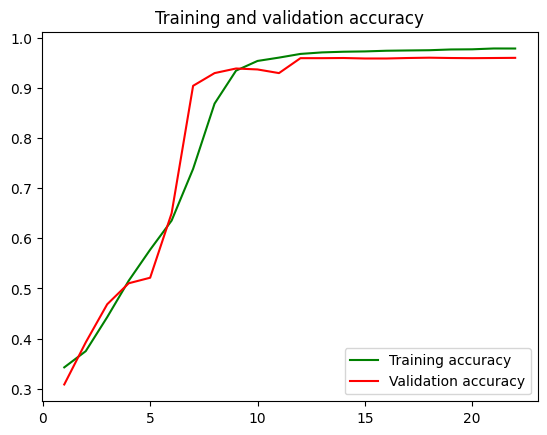

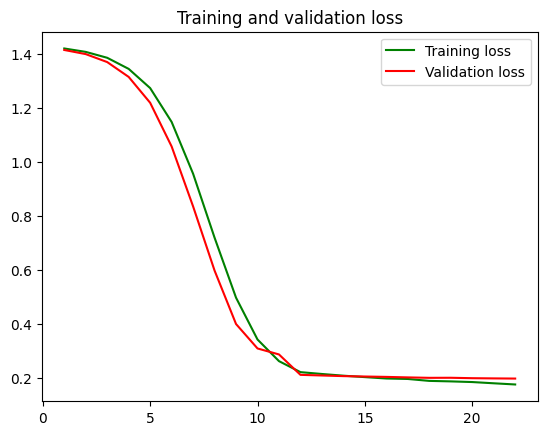

In [ ]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Prediction on  Unseen TestData**

In [30]:
y_pred_test=[]
y_true_test=[]
images=[]

for inputs, labels in test_data:

  predictions_test =  dmvan_model.predict(inputs, batch_size=32, verbose=0)
  y_pred_test.extend(predictions_test) # Save Prediction

  images.extend(inputs[3])
  y_true_test.extend(labels)

In [31]:
pred_test_class = np.argmax(y_pred_test, axis= -1)
y_test = np.argmax(y_true_test, axis= -1)

Confusion matrix, without normalization
[[ 939    9    0   43]
 [  11  808    1   15]
 [   6    1 1136    4]
 [  45   14    2  913]]
              precision    recall  f1-score   support

       Angry    0.93806   0.94753   0.94277       991
     Disgust    0.97115   0.96766   0.96941       835
       Happy    0.99737   0.99041   0.99388      1147
         Sad    0.93641   0.93737   0.93689       974

    accuracy                        0.96174      3947
   macro avg    0.96075   0.96074   0.96074      3947
weighted avg    0.96189   0.96174   0.96181      3947

Accuracy:  0.96174
Precision:  0.96075
Recall:  0.96074
f1_metric:  0.96074


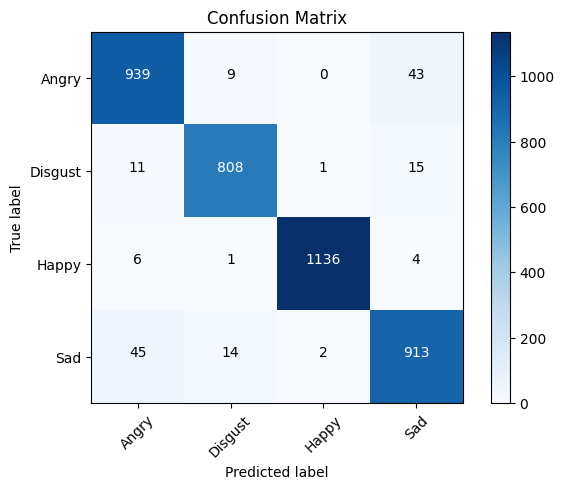

In [32]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import itertools
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred_test_class)

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['Angry','Disgust', 'Happy', 'Sad']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

from sklearn.metrics import classification_report
target_names =  ['Angry','Disgust', 'Happy', 'Sad']
print(classification_report(y_test, pred_test_class, target_names=target_names, digits=5))

accuracy = accuracy_score(y_test, pred_test_class)
print("Accuracy:  {:.5f}".format(accuracy))

precision = precision_score(y_test, pred_test_class, average = 'macro')
print("Precision:  {:.5f}".format(precision))

recall = recall_score(y_test, pred_test_class, average = 'macro')
print("Recall:  {:.5f}".format(recall))

f1_metric = f1_score(y_test, pred_test_class, average = 'macro')
print("f1_metric:  {:.5f}".format(f1_metric))

Normalized confusion matrix
[[9.47527750e-01 9.08173562e-03 0.00000000e+00 4.33905146e-02]
 [1.31736527e-02 9.67664671e-01 1.19760479e-03 1.79640719e-02]
 [5.23103749e-03 8.71839582e-04 9.90409765e-01 3.48735833e-03]
 [4.62012320e-02 1.43737166e-02 2.05338809e-03 9.37371663e-01]]


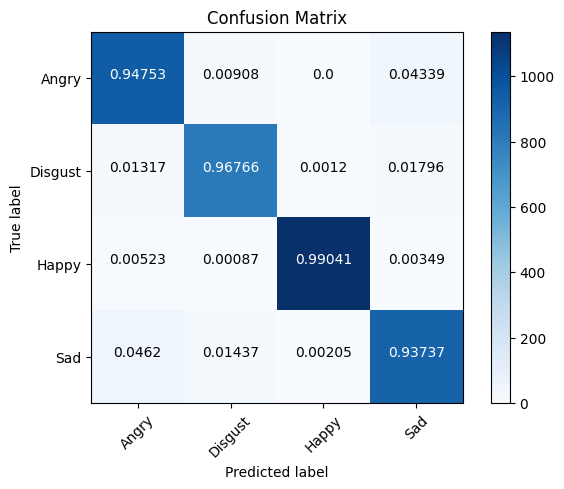

In [33]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],5),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_test, pred_test_class)

cm_plot_labels = ['Angry','Disgust', 'Happy', 'Sad']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix',normalize=True)

**CONSTANTS**

In [34]:
IMAGE_DIM = (224,224,3)
Classes={0:'Angry',1:'Disgust',2:'Happy',3:'Sad'}

import cv2
def image_preprocessing(img):
  """
  Image Preprocessing Are Applied Here.
  Args:\n
    img: Numpy or Tensor With Rank 3.
  Return:\n
    img: Numpy or Tensor Has The Same Shape.
  """
  img *= 1/255.0
  return img

**Explain The Model using LIME**

In [35]:
!pip -q install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [36]:
import lime
from lime.lime_image import LimeImageExplainer
from lime.lime_text import LimeTextExplainer
from skimage.io import imread
from skimage.segmentation import mark_boundaries

In [37]:
global exp_img, exp_text

In [38]:
def min_max_rescaling(numbers):
  indices, numbers = [x[0] for x in numbers], [x[1] for x in numbers]
  min_, max_ = min(numbers), max(numbers)
  denamenator =  max_ - min_
  return [(i, -1 + (2*(number-min_))/denamenator) for i, number in zip(indices, numbers)]

In [39]:
# Creating a segmenter
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm

segmenter = SegmentationAlgorithm(algo_type="slic",
                                  kernel_size=10,
                                  max_dist=5)

In [40]:
def explain_sample(df, classes=Classes.values(), n=1, top_labels=5, hide_color=False, num_features=8, norm=True, num_generated_samples=1000):
  def text_pred(text):
    processed_text = vec_preprocess_text(text)
    ids, segments, masks = prepare(processed_text, tokenizer, max_length)

    ids = tf.reshape(tf.convert_to_tensor(ids),(-1,max_length))
    segments = tf.reshape(tf.convert_to_tensor(segments),(-1,max_length))
    masks = tf.reshape(tf.convert_to_tensor(masks),(-1,max_length))
    imgs = np.array([exp_img] * masks.shape[0])
    preds = dmvan_model.predict([ids,masks,segments,imgs],verbose=0)
    return preds
  def img_pred(imgs):
    processed_text = vec_preprocess_text(exp_text)
    ids, segments, masks = prepare(processed_text, tokenizer, max_length)
    num_ = imgs.shape[0]
    ids = np.array([ids] * num_)
    segments = np.array([segments] * num_)
    masks = np.array([masks] * num_)
    return dmvan_model.predict([ids,masks,segments,imgs],verbose=0)

  samples = df.sample(n)
  images_path = samples["image"]
  texts = samples['text']
  labels = samples['label']
  image_explainer = LimeImageExplainer()
  text_explainer = LimeTextExplainer(class_names=classes)
  for image_path, text, label in zip(images_path.values,texts.values,labels.values):
    print("True Label: ",label)
    exp_img = image_preprocessing(cv2.resize(imread(image_path).astype('float64'),IMAGE_DIM[:2]))
    exp_text = text
    image_explanation = image_explainer.explain_instance(exp_img, img_pred, top_labels=top_labels, hide_color=hide_color, segmentation_fn=segmenter, random_seed=5, num_samples=num_generated_samples)
    text_explanation = text_explainer.explain_instance(exp_text, text_pred, top_labels=top_labels, num_samples=num_generated_samples)
    if norm:
      text_explanation.local_exp = {k:min_max_rescaling(v) for k,v in text_explanation.local_exp.items()}

    temp, mask = image_explanation.get_image_and_mask(image_explanation.top_labels[0], positive_only=False, num_features=num_features, hide_rest=False)
    fig, ax = plt.subplots(1,2,figsize=(10, 10))
    ax[0].imshow(exp_img)
    ax[1].imshow(mark_boundaries(temp , mask))
    text_explanation.show_in_notebook(text=True)

True Label:  Disgust


  0%|          | 0/800 [00:00<?, ?it/s]

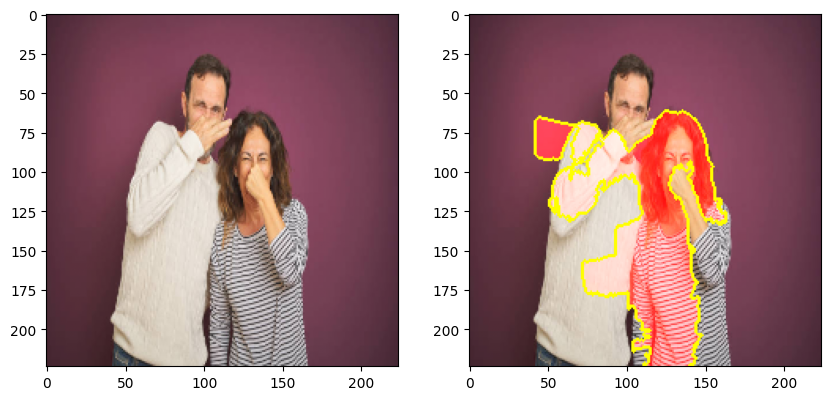

In [ ]:
explain_sample(test,[value for value in Classes.values()],num_generated_samples=800)

True Label:  Happy


  0%|          | 0/800 [00:00<?, ?it/s]

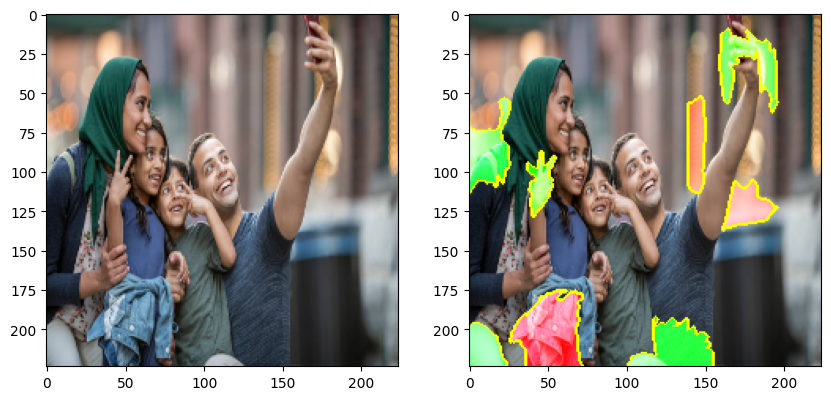

In [ ]:
explain_sample(test,[value for value in Classes.values()],num_generated_samples=800)

True Label:  Angry


  0%|          | 0/800 [00:00<?, ?it/s]

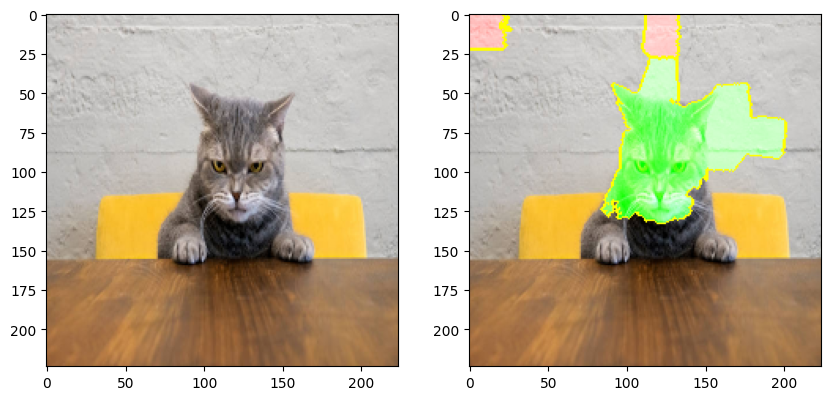

In [ ]:
explain_sample(test,[value for value in Classes.values()],num_generated_samples=800)

True Label:  Sad


  0%|          | 0/800 [00:00<?, ?it/s]

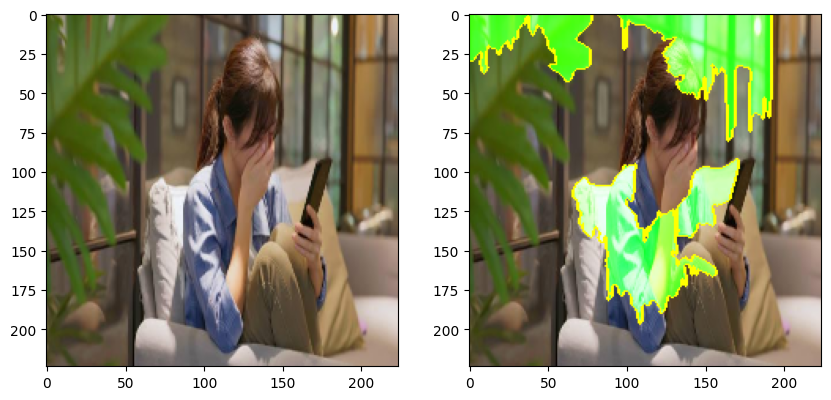

In [ ]:
explain_sample(test,[value for value in Classes.values()],num_generated_samples=800)